In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

In [2]:
dir_dataset = "datasety/"
train_x = np.load(dir_dataset + 'train_x.npy')
train_y = np.load(dir_dataset + 'train_y.npy')

test_x = np.load(dir_dataset + 'test_x.npy')
test_y = np.load(dir_dataset + 'test_y.npy')

In [3]:
# from random import shuffle
# ind = [i for i in range(len(train_y))]
# shuffle(ind)
# train_x = train_x[ind]
# train_y = train_y[ind]

In [4]:
# print(train_x.shape)
# print(train_y.shape)

In [3]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle

In [4]:
class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((2,))
        label_temp[label] = 1
        return torch.tensor(cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)).unsqueeze(0), torch.tensor(label_temp)

In [5]:
from torch.utils.data import DataLoader
training_data = NCarsImageDataset("./Datasety/train")
test_data = NCarsImageDataset("./Datasety/test")



In [6]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [7]:
from torch import nn

In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()).to("cuda")
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)).to("cuda")
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()).to("cuda")
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)).to("cuda")
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()).to("cuda")
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()).to("cuda")
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)).to("cuda")
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()).to("cuda")
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()).to("cuda")
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)).to("cuda")
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()).to("cuda")
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()).to("cuda")
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)).to("cuda")
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU()).to("cuda")
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()).to("cuda")
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)).to("cuda")

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def train(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001):
        total_step = len(train_loader)
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.to("cuda")
                labels = labels.to("cuda")

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                del images, labels, outputs
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in valid_loader:
                    images = images.to("cuda")
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels, 1).indices)).sum().item()
                    del images, labels, outputs

                print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

In [16]:
# creating the model

model = VGG16()


In [14]:
model.train(train_dataloader, test_dataloader,num_epochs=50, learning_rate=5e-4)

100%|██████████| 269/269 [00:58<00:00,  4.62it/s]


Epoch [1/50], Step [269/269], Loss: 0.7056
Accuracy of the network on the 5000 validation images: 50.714534681073545 %


100%|██████████| 269/269 [00:56<00:00,  4.72it/s]


Epoch [2/50], Step [269/269], Loss: 0.6987
Accuracy of the network on the 5000 validation images: 51.423260137097714 %


100%|██████████| 269/269 [00:57<00:00,  4.71it/s]


Epoch [3/50], Step [269/269], Loss: 0.6870
Accuracy of the network on the 5000 validation images: 52.143604043220634 %


100%|██████████| 269/269 [00:56<00:00,  4.77it/s]


Epoch [4/50], Step [269/269], Loss: 0.6841
Accuracy of the network on the 5000 validation images: 51.45811548739398 %


 21%|██        | 57/269 [00:12<00:45,  4.64it/s]


KeyboardInterrupt: 

In [16]:
model.train(train_dataloader, test_dataloader,num_epochs=50)

100%|██████████| 269/269 [00:56<00:00,  4.79it/s]


Epoch [1/50], Step [269/269], Loss: 0.7287
Accuracy of the network on the 5000 validation images: 52.89880329963983 %


100%|██████████| 269/269 [00:53<00:00,  5.05it/s]


Epoch [2/50], Step [269/269], Loss: 0.6936
Accuracy of the network on the 5000 validation images: 54.18845126060184 %


100%|██████████| 269/269 [00:52<00:00,  5.08it/s]


Epoch [3/50], Step [269/269], Loss: 0.6836
Accuracy of the network on the 5000 validation images: 55.26896711978622 %


100%|██████████| 269/269 [00:52<00:00,  5.10it/s]


Epoch [4/50], Step [269/269], Loss: 0.6920
Accuracy of the network on the 5000 validation images: 54.67642616474962 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [5/50], Step [269/269], Loss: 0.6883
Accuracy of the network on the 5000 validation images: 55.478099221563845 %


100%|██████████| 269/269 [00:52<00:00,  5.08it/s]


Epoch [6/50], Step [269/269], Loss: 0.6990
Accuracy of the network on the 5000 validation images: 56.721273382130825 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [7/50], Step [269/269], Loss: 0.7009
Accuracy of the network on the 5000 validation images: 55.21087486929244 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [8/50], Step [269/269], Loss: 0.7018
Accuracy of the network on the 5000 validation images: 54.01417450912049 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [9/50], Step [269/269], Loss: 0.6817
Accuracy of the network on the 5000 validation images: 55.74532357383525 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [10/50], Step [269/269], Loss: 0.6944
Accuracy of the network on the 5000 validation images: 54.88555826652725 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [11/50], Step [269/269], Loss: 0.6785
Accuracy of the network on the 5000 validation images: 54.53700476356454 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [12/50], Step [269/269], Loss: 0.6899
Accuracy of the network on the 5000 validation images: 52.4224468455908 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [13/50], Step [269/269], Loss: 0.6968
Accuracy of the network on the 5000 validation images: 54.32787266178692 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [14/50], Step [269/269], Loss: 0.6806
Accuracy of the network on the 5000 validation images: 52.21331474381318 %


100%|██████████| 269/269 [00:52<00:00,  5.09it/s]


Epoch [15/50], Step [269/269], Loss: 0.6945
Accuracy of the network on the 5000 validation images: 51.1560357848263 %


100%|██████████| 269/269 [00:53<00:00,  5.00it/s]


Epoch [16/50], Step [269/269], Loss: 0.6975
Accuracy of the network on the 5000 validation images: 52.73614499825723 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [17/50], Step [269/269], Loss: 0.6827
Accuracy of the network on the 5000 validation images: 54.31625421168816 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [18/50], Step [269/269], Loss: 0.6969
Accuracy of the network on the 5000 validation images: 51.99256419193679 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [19/50], Step [269/269], Loss: 0.6870
Accuracy of the network on the 5000 validation images: 54.804229115835945 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [20/50], Step [269/269], Loss: 0.6991
Accuracy of the network on the 5000 validation images: 51.30707563611014 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [21/50], Step [269/269], Loss: 0.7028
Accuracy of the network on the 5000 validation images: 52.991750900429885 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [22/50], Step [269/269], Loss: 0.7144
Accuracy of the network on the 5000 validation images: 53.94446380852794 %


100%|██████████| 269/269 [00:53<00:00,  5.01it/s]


Epoch [23/50], Step [269/269], Loss: 0.6947
Accuracy of the network on the 5000 validation images: 51.423260137097714 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [24/50], Step [269/269], Loss: 0.6580
Accuracy of the network on the 5000 validation images: 53.22411990240502 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [25/50], Step [269/269], Loss: 0.6716
Accuracy of the network on the 5000 validation images: 52.689671197862204 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [26/50], Step [269/269], Loss: 0.6923
Accuracy of the network on the 5000 validation images: 51.063088184036246 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [27/50], Step [269/269], Loss: 0.7060
Accuracy of the network on the 5000 validation images: 51.063088184036246 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [28/50], Step [269/269], Loss: 0.6919
Accuracy of the network on the 5000 validation images: 49.843150923666784 %


100%|██████████| 269/269 [00:53<00:00,  5.01it/s]


Epoch [29/50], Step [269/269], Loss: 0.6741
Accuracy of the network on the 5000 validation images: 49.680492622284184 %


100%|██████████| 269/269 [00:53<00:00,  5.01it/s]


Epoch [30/50], Step [269/269], Loss: 0.6556
Accuracy of the network on the 5000 validation images: 46.7177878471012 %


100%|██████████| 269/269 [00:53<00:00,  5.01it/s]


Epoch [31/50], Step [269/269], Loss: 0.6526
Accuracy of the network on the 5000 validation images: 50.94690368304868 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [32/50], Step [269/269], Loss: 0.6897
Accuracy of the network on the 5000 validation images: 48.01905425816196 %


100%|██████████| 269/269 [00:53<00:00,  5.01it/s]


Epoch [33/50], Step [269/269], Loss: 0.6960
Accuracy of the network on the 5000 validation images: 47.345184152434065 %


100%|██████████| 269/269 [00:53<00:00,  5.01it/s]


Epoch [34/50], Step [269/269], Loss: 0.6944
Accuracy of the network on the 5000 validation images: 46.22981294295341 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [35/50], Step [269/269], Loss: 0.7035
Accuracy of the network on the 5000 validation images: 48.042291158359475 %


100%|██████████| 269/269 [00:53<00:00,  5.01it/s]


Epoch [36/50], Step [269/269], Loss: 0.6889
Accuracy of the network on the 5000 validation images: 51.12118043453003 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [37/50], Step [269/269], Loss: 0.6636
Accuracy of the network on the 5000 validation images: 47.24061810154525 %


100%|██████████| 269/269 [00:53<00:00,  5.01it/s]


Epoch [38/50], Step [269/269], Loss: 0.7017
Accuracy of the network on the 5000 validation images: 47.21738120134774 %


100%|██████████| 269/269 [00:53<00:00,  5.01it/s]


Epoch [39/50], Step [269/269], Loss: 0.6957
Accuracy of the network on the 5000 validation images: 44.04554432438713 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [40/50], Step [269/269], Loss: 0.6824
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [41/50], Step [269/269], Loss: 0.6515
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [42/50], Step [269/269], Loss: 0.6952
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


100%|██████████| 269/269 [00:53<00:00,  5.03it/s]


Epoch [43/50], Step [269/269], Loss: 0.6820
Accuracy of the network on the 5000 validation images: 46.102009991867085 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [44/50], Step [269/269], Loss: 0.6765
Accuracy of the network on the 5000 validation images: 51.051469733937495 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [45/50], Step [269/269], Loss: 0.6765
Accuracy of the network on the 5000 validation images: 47.11281515045893 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [46/50], Step [269/269], Loss: 0.6944
Accuracy of the network on the 5000 validation images: 45.33519228534914 %


100%|██████████| 269/269 [00:54<00:00,  4.95it/s]


Epoch [47/50], Step [269/269], Loss: 0.7065
Accuracy of the network on the 5000 validation images: 47.43813175322412 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [48/50], Step [269/269], Loss: 0.7023
Accuracy of the network on the 5000 validation images: 44.870454281398864 %


100%|██████████| 269/269 [00:53<00:00,  5.03it/s]


Epoch [49/50], Step [269/269], Loss: 0.6535
Accuracy of the network on the 5000 validation images: 50.85395608225863 %


100%|██████████| 269/269 [00:53<00:00,  5.02it/s]


Epoch [50/50], Step [269/269], Loss: 0.6705
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
    def train(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001):
        total_step = len(train_loader)
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

        for epoch in range(num_epochs):
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.to("cuda")
                labels = labels.to("cuda")

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                
                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels, 1).indices)).sum().item()
                total += labels.size(0)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                del images, labels, outputs

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, loss.item(), (float(correct))/total))

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in valid_loader:
                    images = images.to("cuda")
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels, 1).indices)).sum().item()
                    del images, labels, outputs

                print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

In [33]:
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3]).to("cuda")


In [34]:
model_resnet.train(train_dataloader, test_dataloader,num_epochs=50)

100%|██████████| 269/269 [00:19<00:00, 13.84it/s]


Epoch [1/50], Step [269/269], Loss: 0.7119, Accuracy: 0.4991
Accuracy of the network on the 5000 validation images: 53.32868595329383 %


100%|██████████| 269/269 [00:16<00:00, 16.45it/s]


Epoch [2/50], Step [269/269], Loss: 0.6632, Accuracy: 0.4888
Accuracy of the network on the 5000 validation images: 49.05309631695132 %


100%|██████████| 269/269 [00:16<00:00, 16.38it/s]


Epoch [3/50], Step [269/269], Loss: 0.6940, Accuracy: 0.4951
Accuracy of the network on the 5000 validation images: 48.23980481003834 %


100%|██████████| 269/269 [00:16<00:00, 16.36it/s]


Epoch [4/50], Step [269/269], Loss: 0.7331, Accuracy: 0.4983
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


100%|██████████| 269/269 [00:16<00:00, 16.31it/s]


Epoch [5/50], Step [269/269], Loss: 0.6946, Accuracy: 0.5020
Accuracy of the network on the 5000 validation images: 53.42163355408388 %


100%|██████████| 269/269 [00:16<00:00, 16.21it/s]


Epoch [6/50], Step [269/269], Loss: 0.7123, Accuracy: 0.4949
Accuracy of the network on the 5000 validation images: 49.05309631695132 %


100%|██████████| 269/269 [00:16<00:00, 16.01it/s]


Epoch [7/50], Step [269/269], Loss: 0.7302, Accuracy: 0.4953
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


100%|██████████| 269/269 [00:16<00:00, 16.23it/s]


Epoch [8/50], Step [269/269], Loss: 0.7418, Accuracy: 0.5024
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


100%|██████████| 269/269 [00:16<00:00, 15.94it/s]


Epoch [9/50], Step [269/269], Loss: 0.7029, Accuracy: 0.5078
Accuracy of the network on the 5000 validation images: 49.97095387475311 %


100%|██████████| 269/269 [00:16<00:00, 16.20it/s]


Epoch [10/50], Step [269/269], Loss: 0.6938, Accuracy: 0.5046
Accuracy of the network on the 5000 validation images: 53.99093760892297 %


100%|██████████| 269/269 [00:16<00:00, 16.13it/s]


Epoch [11/50], Step [269/269], Loss: 0.6880, Accuracy: 0.5064
Accuracy of the network on the 5000 validation images: 54.58347856395957 %


100%|██████████| 269/269 [00:16<00:00, 16.23it/s]


Epoch [12/50], Step [269/269], Loss: 0.6871, Accuracy: 0.5089
Accuracy of the network on the 5000 validation images: 56.96526083420472 %


100%|██████████| 269/269 [00:16<00:00, 16.27it/s]


Epoch [13/50], Step [269/269], Loss: 0.6892, Accuracy: 0.5012
Accuracy of the network on the 5000 validation images: 51.34193098640641 %


100%|██████████| 269/269 [00:16<00:00, 16.17it/s]


Epoch [14/50], Step [269/269], Loss: 0.7160, Accuracy: 0.4999
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


100%|██████████| 269/269 [00:16<00:00, 15.86it/s]


Epoch [15/50], Step [269/269], Loss: 0.6820, Accuracy: 0.4997
Accuracy of the network on the 5000 validation images: 51.20250958522133 %


100%|██████████| 269/269 [00:16<00:00, 15.99it/s]


Epoch [16/50], Step [269/269], Loss: 0.6648, Accuracy: 0.5068
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


100%|██████████| 269/269 [00:16<00:00, 16.01it/s]


Epoch [17/50], Step [269/269], Loss: 0.6930, Accuracy: 0.5091
Accuracy of the network on the 5000 validation images: 47.67050075519926 %


100%|██████████| 269/269 [00:16<00:00, 16.23it/s]


Epoch [18/50], Step [269/269], Loss: 0.7001, Accuracy: 0.5094
Accuracy of the network on the 5000 validation images: 53.64238410596027 %


100%|██████████| 269/269 [00:16<00:00, 16.29it/s]


Epoch [19/50], Step [269/269], Loss: 0.6971, Accuracy: 0.5098
Accuracy of the network on the 5000 validation images: 51.08632508423376 %


100%|██████████| 269/269 [00:16<00:00, 16.30it/s]


Epoch [20/50], Step [269/269], Loss: 0.6810, Accuracy: 0.5105
Accuracy of the network on the 5000 validation images: 49.05309631695132 %


100%|██████████| 269/269 [00:16<00:00, 16.29it/s]


Epoch [21/50], Step [269/269], Loss: 0.6836, Accuracy: 0.5061
Accuracy of the network on the 5000 validation images: 51.074706634135005 %


100%|██████████| 269/269 [00:16<00:00, 16.16it/s]


Epoch [22/50], Step [269/269], Loss: 0.6893, Accuracy: 0.5054
Accuracy of the network on the 5000 validation images: 51.16765423492506 %


100%|██████████| 269/269 [00:16<00:00, 16.27it/s]


Epoch [23/50], Step [269/269], Loss: 0.7046, Accuracy: 0.4991


KeyboardInterrupt: 

tensor([0., 1.], dtype=torch.float64)


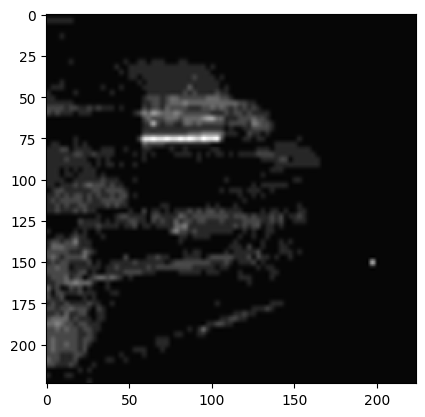

tensor([0., 1.], dtype=torch.float64)


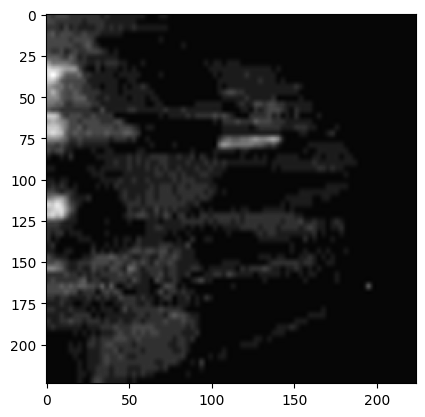

tensor([0., 1.], dtype=torch.float64)


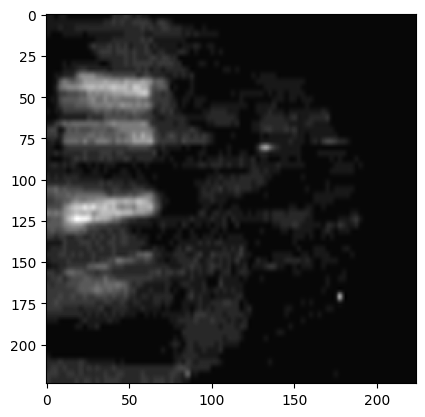

tensor([0., 1.], dtype=torch.float64)


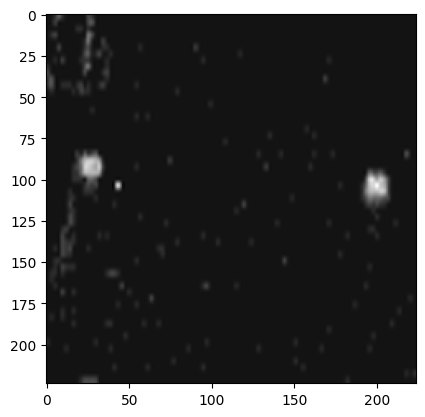

tensor([0., 1.], dtype=torch.float64)


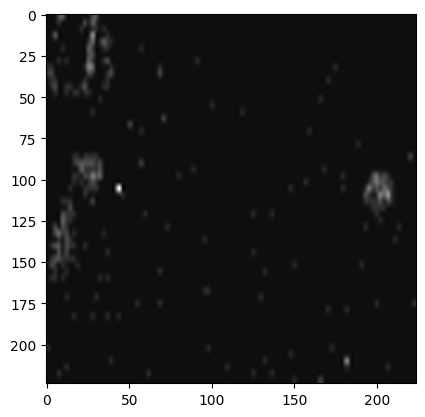

tensor([0., 1.], dtype=torch.float64)


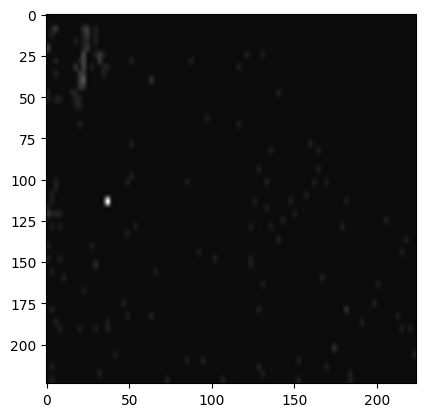

tensor([0., 1.], dtype=torch.float64)


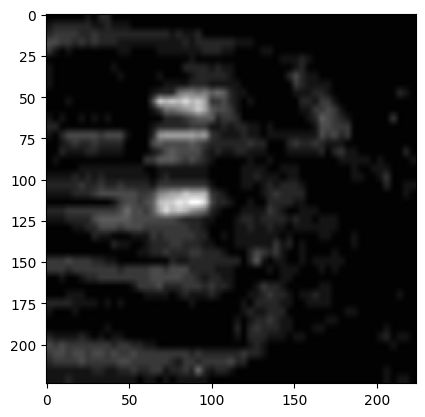

tensor([0., 1.], dtype=torch.float64)


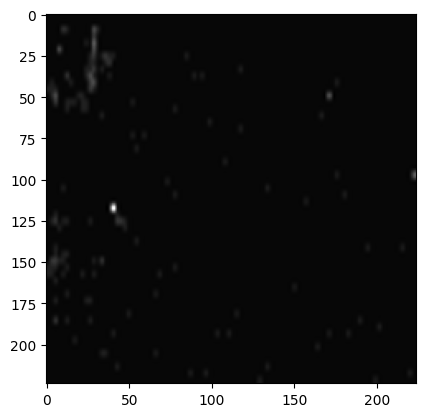

tensor([0., 1.], dtype=torch.float64)


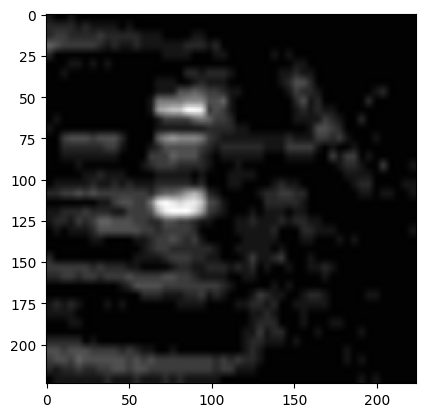

tensor([0., 1.], dtype=torch.float64)


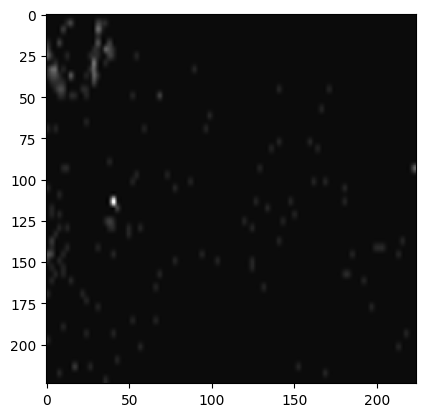

In [39]:
import matplotlib.pyplot as plt
for i in range(4000,4010):
    plt.imshow(train_dataloader.dataset[i][0][0,:,:])
    plt.gray()
    print(train_dataloader.dataset[i][1])
    plt.show()

1


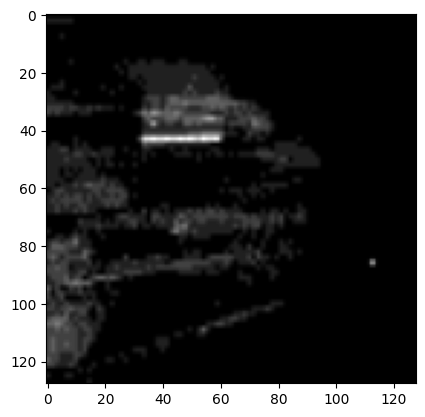

1


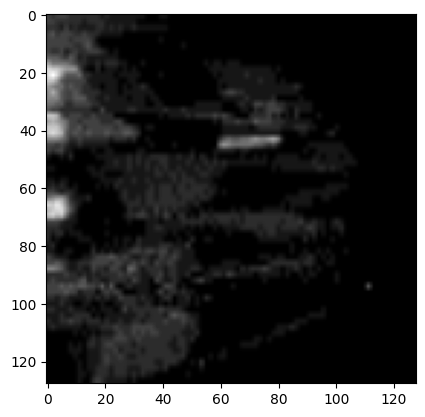

1


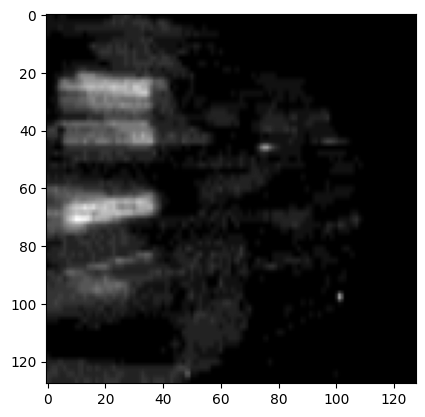

1


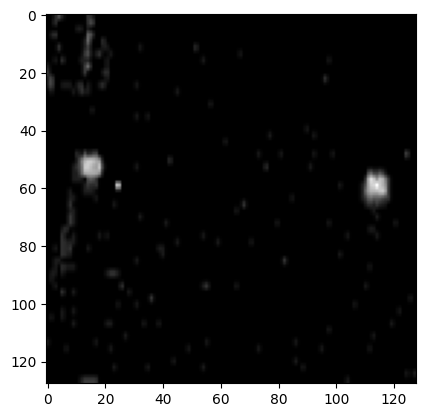

1


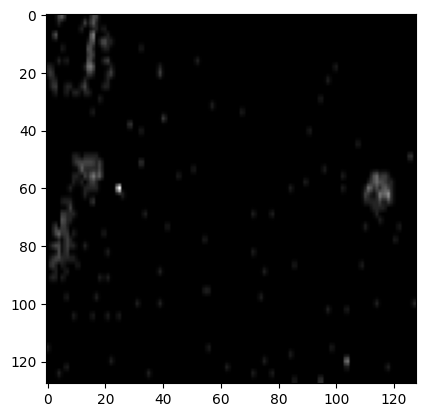

1


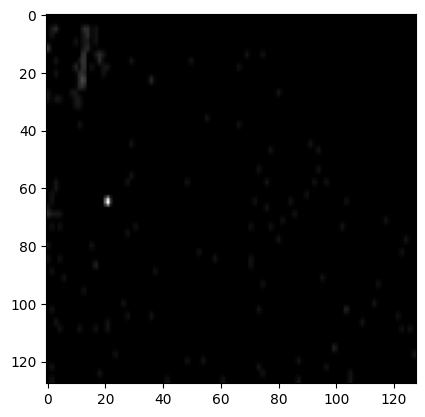

1


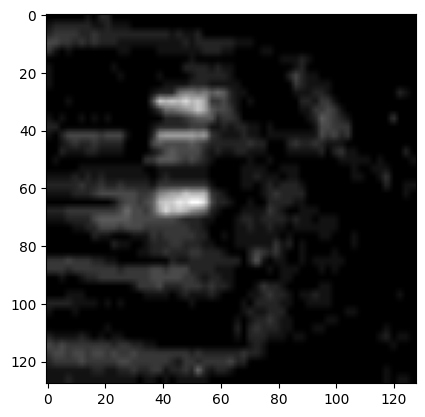

1


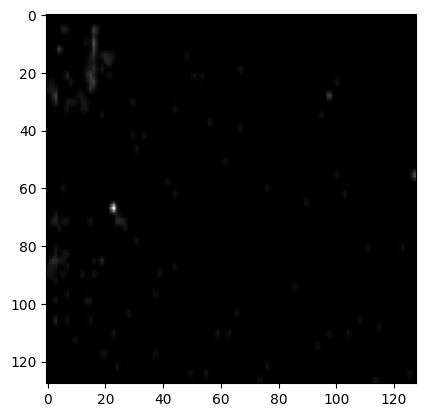

1


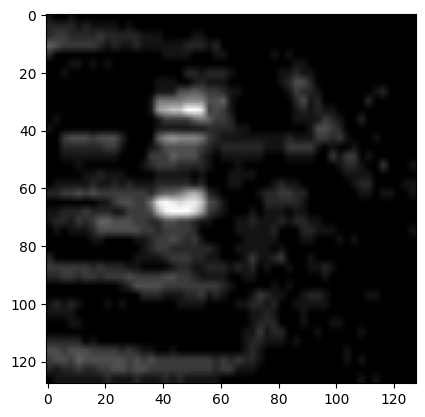

1


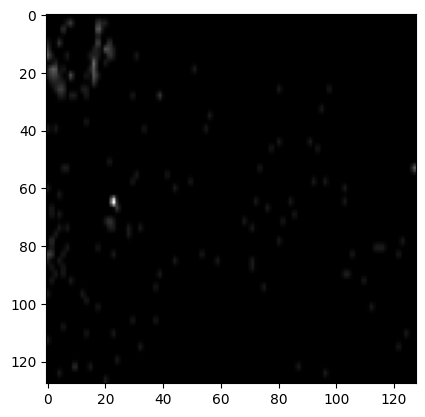

In [14]:
import matplotlib.pyplot as plt
for i in range(4000,4010):
    plt.imshow(train_x[i])
    print(train_y[i])
    plt.show()